In [2]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import theano

### Generating Data

In [3]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

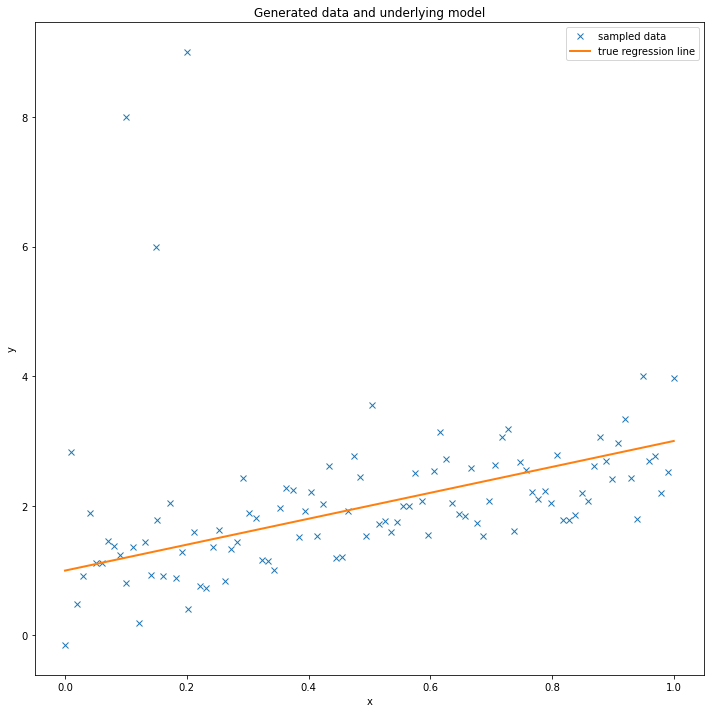

In [4]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [5]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(progressbar=False, tune=1000)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The acceptance probability does not match the target. It is 0.8947530135301681, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Program Files\Anaconda\lib\site-packages\pymc3\plots\posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


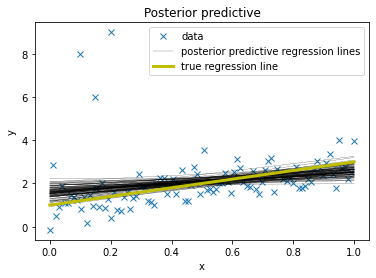

In [8]:
plt.subplot(111, xlabel='x', ylabel='y', 
            title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data')
pm.plots.plot_posterior_predictive_glm(trace, samples=100, 
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')

plt.legend(loc=0);

As you can see, the fit is quite skewed and we have a fair amount of uncertainty in our estimate as indicated by the wide range of different posterior predictive regression lines. Why is this? The reason is that the normal distribution does not have a lot of mass in the tails and consequently, an outlier will affect the fit strongly.

A Frequentist would estimate a Robust Regression and use a non-quadratic distance measure to evaluate the fit.

But what's a Bayesian to do? Since the problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the Student T distribution which has heavier tails as shown next (I read about this trick in "The Kruschke", aka the puppy-book; but I think Gelman was the first to formulate this).

In [11]:
### Normal and T distribution

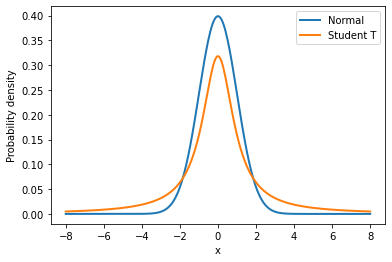

In [10]:
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

To define the usage of a T distribution in PyMC3 we can pass a family object -- StudentT -- that specifies that our data is Student T-distributed (see glm.families for more choices).

In [12]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(progressbar=False, tune=1000)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.


C:\Program Files\Anaconda\lib\site-packages\pymc3\plots\posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


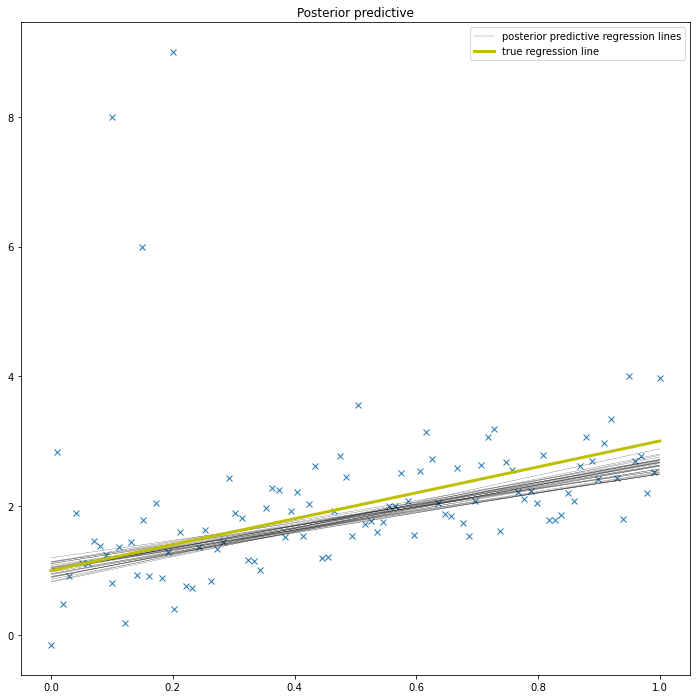

In [13]:
plt.figure(figsize=(12, 12))
plt.plot(x_out, y_out, 'x')
pm.plots.plot_posterior_predictive_glm(trace_robust,
                                       label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')
plt.legend();